In [2]:
import os 
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat
from scipy.signal import resample
from pathlib import Path



# DaLiA Dataset

In [3]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/DaLiA/data/PPG_FieldStudy"
participant_paths = glob.glob(os.path.join(data_path, '**', '*_quest.csv'), recursive=True)
series = []
for participant in participant_paths:
   row = pd.read_csv(participant, header=None).T
   row.columns = [el.split(" ")[1] for el in row.iloc[0]]
   row = row.drop(row.index[0])
   series.append(row) 

df = pd.concat(series, ignore_index=True)
df

,SUBJECT_ID,AGE,GENDER,HEIGHT,WEIGHT,SKIN,SPORT
0,S1,34,m,182,78,3,6
1,S10,55,f,164,56,4,5
2,S11,24,f,168,62,3,5
3,S12,43,m,195,105,3,5
4,S13,21,f,170,63,3,6
5,S14,26,f,170,67,3,4
6,S15,28,m,183,79,2,5
7,S2,28,m,189,80,3,5
8,S3,25,m,170,60,3,5
9,S4,25,m,168,57,4,5


In [64]:
import pickle

with open(data_path + "/S1/S1.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")
data

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224]),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15]], dt

In [67]:
acc = data['signal']['wrist']['ACC']
time = 8 + 2 * (data['label'].shape[0] - 1)
print(time)
print(acc.shape[0] / 32)

9212
9212.0


In [61]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

# Input data (replace with your actual data)
vec = acc[:,0]

# Parameters
window_size = 256  # 8 seconds at 32Hz
stride = 64        # 2 seconds at 32Hz

# Compute sliding window mean
windows = sliding_window_view(vec, window_shape=window_size)[::stride]
window_means = np.mean(windows, axis=1)

# Output shape
print("Window means shape:", window_means.shape)

Window means shape: (4603,)


In [82]:
data['label'].shape

(4603,)

In [80]:
import numpy as np

# Example vector
x = acc[:,0]  # or whatever your 1D array is

# Parameters
window_size = 256
stride = 64

print((x.size - window_size)// stride + 1)

# Create the sliding windows
shape = ((x.size - window_size) // stride + 1, window_size)
strides = (x.strides[0] * stride, x.strides[0])
windows = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

# Compute the mean for each window
means = windows.mean(axis=1)
means.shape


4603


(4603,)

In [79]:
acc[:,0].shape[0] / 32

9212.0

(11431,)


<Axes: >

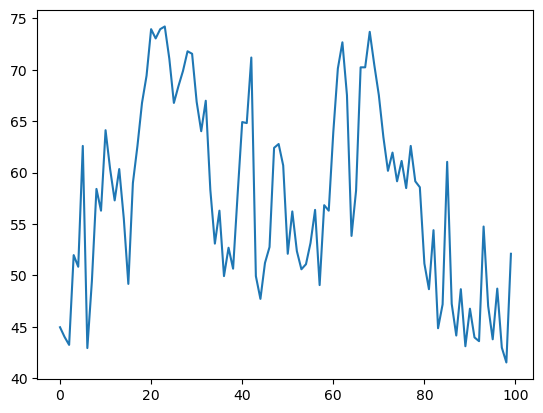

In [19]:
rpeaks = data['rpeaks']
print(rpeaks.shape)
rpeaks = rpeaks / 700.0
rr_intervals = np.diff(rpeaks)
hr = 60 / rr_intervals 
pd.Series(hr[:100]).plot()

<Axes: >

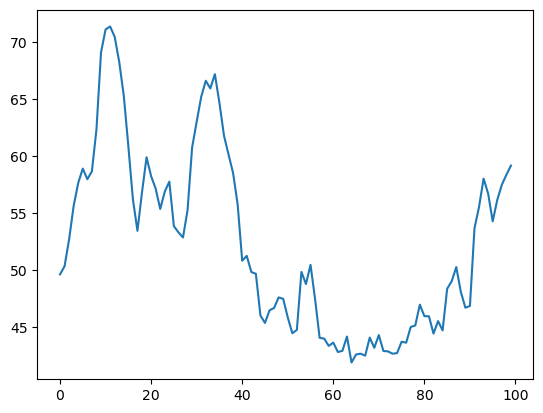

In [18]:
pd.Series(data['label'][:100]).plot()

In [10]:
data['signal']['wrist']['ACC'].shape

(294784, 3)

In [15]:
294784 / 11431

25.788120024494795

In [22]:
len(np.where(data['activity']==1.0)[0]) 

2800

C:\Users\cleme\AppData\Local\Temp\ipykernel_15288\3397908756.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


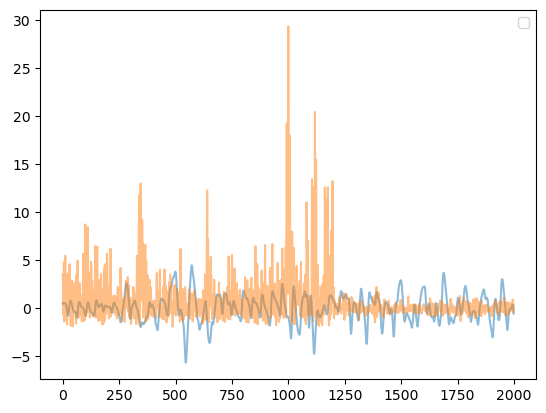

In [25]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/euler"
np_data = np.load(data_path + "/dalia_preprocessed/S1.npz")

def scale(data):
    return (data - np.mean(data)) / (np.std(data) + 1e-8)

series = np_data['bvp'][:, 0]
series = scale(series)

activity = resample(np_data['wrist_acc'], len(np_data['bvp']))
activity = activity[:,0]**2 + activity[:, 1]**2 + activity[:,2]**2
activity = scale(activity)

highest_activity = np.argmax(activity)
lower = max(highest_activity-1000,0)
upper = min(highest_activity+1000,len(np_data['bvp']))
serie = pd.Series(series[lower: upper])
serie.plot(alpha=0.5)
activity = pd.Series(activity[lower:upper])
activity.plot(alpha=0.5)
plt.legend()

<Axes: >

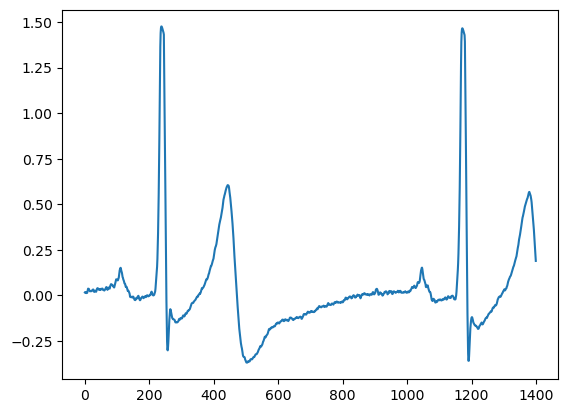

In [63]:
pd.Series(data['signal']['chest']['ECG'][:1400][:,0]).plot()

In [ ]:
data['signal']['wrist']['BVP']

(589568, 1)

# UCIHAR Dataset

In [27]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/UCIHAR/UCI HAR Dataset/UCI HAR Dataset/"
data = np.load(datadir + "ucihar_preprocessed.npz")
data

NpzFile 'C:/Users/cleme/ETH/Master/Thesis/data/UCIHAR/UCI HAR Dataset/UCI HAR Dataset/ucihar_preprocessed.npz' with keys: train_val_subjects, y_train, y_test, X_train, X_test

In [33]:
data['train_val_subjects'].shape[0] == data['X_train'].shape[0]

True

In [34]:
data['X_test'].shape[0] == data['y_test'].shape[0]

True

In [36]:
pd.Series(data['y_train']).unique()

array([5., 4., 6., 1., 3., 2.])

In [37]:
inertial = "C:/Users/cleme/ETH/Master/Thesis/data/euler/UCIHAR/train/Inertial Signals/"
data_x = np.loadtxt(inertial + "total_acc_x_train.txt")
data_x.shape

(7352, 128)

In [25]:
y_train = np.loadtxt(datadir + "train/y_train.txt")
y_test = np.loadtxt(datadir + "test/y_test.txt")
print(pd.Series(y_train).unique())
print(pd.Series(y_test).unique())

[ 1.  3.  5.  6.  7.  8. 11. 14. 15. 16. 17. 19. 21. 22. 23. 25. 26. 27.
 28. 29. 30.]
[ 2.  4.  9. 10. 12. 13. 18. 20. 24.]


array([ 2,  4,  9, 10, 12, 13, 18, 20, 24])

In [ ]:
body_acc_x = np.loadtxt(datadir + "Inertial Signals/body_acc_x_train.txt")

(7352, 128)

In [14]:
print(x_train.shape)

(7352, 561)


In [19]:
pd.Series(subjects).unique()

array([ 1.,  3.,  5.,  6.,  7.,  8., 11., 14., 15., 16., 17., 19., 21.,
       22., 23., 25., 26., 27., 28., 29., 30.])

# USC Dataset

In [47]:

datadir = "C:/Users/cleme/ETH/Master/Thesis/data/USC/USC-HAD/"
file_dir = datadir + "Subject1/a1t1.mat"
data = loadmat(file_dir)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sun Oct 17 17:39:12 2010',
 '__version__': '1.0',
 '__globals__': [],
 'title': array(['USC Human Motion Dataset'], dtype='<U24'),
 'version': array(['1.0'], dtype='<U3'),
 'date': array(['Oct-2010'], dtype='<U8'),
 'subject': array(['1'], dtype='<U1'),
 'age': array(['27'], dtype='<U2'),
 'height': array(['164cm'], dtype='<U5'),
 'weight': array(['43kg'], dtype='<U4'),
 'activity': array(['walking-forward'], dtype='<U15'),
 'activity_number': array(['1'], dtype='<U1'),
 'trial': array(['1'], dtype='<U1'),
 'sensor_location': array(['front-right-hip'], dtype='<U15'),
 'sensor_orientation': array(['x-gravity-y-walking-direction-z-vertical-to-walking-direction'],
       dtype='<U61'),
 'sensor_readings': array([[ 1.16277993e+00, -1.89287394e-01, -2.95780540e-01,
         -1.87813244e+01,  3.36187220e+00, -1.68631287e+01],
        [ 1.03229570e+00, -2.00144812e-01, -3.76303941e-01,
         -1.35445089e+01,  5.77886438e+00

In [56]:

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[list(range(1, 13))], sparse_output=False)
encoder.fit_transform(np.array(['11']).astype(int)[np.newaxis,:])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [33]:
subjects = {"age" : [], "height": [], "weight": []}
for i in range(1,15):
    file_dir = datadir + f"Subject{i}/a1t1.mat"
    data = loadmat(file_dir)
    subjects['age'].append(int(data['age'][0]))
    subjects['height'].append(int(data['height'][0][:3]))
    subjects['weight'].append(int(data['weight'][0][:2]))

In [42]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

data = pd.DataFrame(subjects)

# Use KMeans to create clusters (diversity groups)
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['age', 'height', 'weight']])

# Stratify by cluster to maintain diversity
train_val, test = train_test_split(data, test_size=3, stratify=data['cluster'], random_state=42)
train, val = train_test_split(train_val, test_size=3, stratify=train_val['cluster'], random_state=42)

# Drop cluster column before using
train = train.drop(columns='cluster')
val = val.drop(columns='cluster')
test = test.drop(columns='cluster')

print("Train subjects:\n", sorted(train.index + 1))
print("\nValidation subjects:\n", sorted(val.index + 1))
print("\nTest subjects:\n", sorted(test.index + 1))

Train subjects:
 [1, 2, 4, 5, 7, 10, 11, 14]

Validation subjects:
 [3, 6, 8]

Test subjects:
 [9, 12, 13]


c:\Users\cleme\miniconda3\envs\dsl\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# Capture 24

In [73]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Capture24/capture24/"
df = pd.read_csv(datadir + "P001.csv")
df

C:\Users\cleme\AppData\Local\Temp\ipykernel_22704\1724369356.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "P001.csv")


,time,x,y,z,annotation
0,2016-11-13 02:18:00.000000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
1,2016-11-13 02:18:00.010000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2,2016-11-13 02:18:00.020000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
3,2016-11-13 02:18:00.030000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
4,2016-11-13 02:18:00.040000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
...,...,...,...,...,...
10019996,2016-11-14 06:07:59.960000,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95
10019997,2016-11-14 06:07:59.970000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
10019998,2016-11-14 06:07:59.980000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
10019999,2016-11-14 06:07:59.990000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95


In [78]:


# Assume your DataFrame is called df and has a column "annotation"
df['met'] = df['annotation'].str.extract(r'([0-9]*\.?[0-9]+)$').astype(float)
df

,time,x,y,z,annotation,met
0,2016-11-13 02:18:00.000000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,0.95
1,2016-11-13 02:18:00.010000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,0.95
2,2016-11-13 02:18:00.020000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,0.95
3,2016-11-13 02:18:00.030000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,0.95
4,2016-11-13 02:18:00.040000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,0.95
...,...,...,...,...,...,...
10019996,2016-11-14 06:07:59.960000,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95,0.95
10019997,2016-11-14 06:07:59.970000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,0.95
10019998,2016-11-14 06:07:59.980000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,0.95
10019999,2016-11-14 06:07:59.990000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,0.95


In [79]:
df['met'] = df['annotation'].str.split().str[-1].astype(float)


In [85]:
type(df.drop(["time", "annotation"], axis=1).values)

numpy.ndarray

# WildPPG

In [52]:
datadir="C:/Users/cleme/ETH/Master/Thesis/data/euler/wildppg_preprocessed/"
file_path = datadir + "WildPPG_Part_an0.npz"
data = np.load(file_path)

In [ ]:
datadir="C:/Users/cleme/ETH/Master/Thesis/data/euler/wildppg_preprocessed/"

In [115]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/WildPPG/data"
file_pat = datadir + "/WildPPG_Part_an0.mat"
data = loadmat(file_pat)

In [117]:
data['sternum']

array([[(array([[(array([[128]]), array(['x-axis of MEMS accelerometer'], dtype='<U28'), array([[-0.97626238, -0.97447525, -0.98652476, ..., -0.94178734,
                        -0.94271266, -0.944     ]]))                                                                                                    ]],
              dtype=[('fs', 'O'), ('descr', 'O'), ('v', 'O')]), array([[(array([[128]]), array(['y-axis of MEMS accelerometer'], dtype='<U28'), array([[-0.07147525, -0.056     , -0.03873762, ...,  0.15778734,
                         0.14528734,  0.16478733]]))                                                                                                    ]],
              dtype=[('fs', 'O'), ('descr', 'O'), ('v', 'O')]), array([[(array([[128]]), array(['z-axis of MEMS accelerometer'], dtype='<U28'), array([[0.32747525, 0.32628713, 0.34273762, ..., 0.37821266, 0.384     ,
                        0.36478733]]))                                                                      

In [101]:
ecg = data['sternum']['ecg'][0][0][0][0][2].squeeze()

In [112]:
import neurokit2 as nk 
signals, info = nk.ecg_process(ecg, sampling_rate=128)

c:\Users\cleme\miniconda3\envs\dsl\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\cleme\miniconda3\envs\dsl\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


In [113]:
ecg_time = ecg.shape[0] / 128
time_rpeaks = info['ECG_R_Peaks'] / 128
diffed = np.diff(time_rpeaks)
hr = 60 / diffed 
window_size = 128 * 8 
stride = 128 * 2 
ecg_time

44368.0

<Axes: >

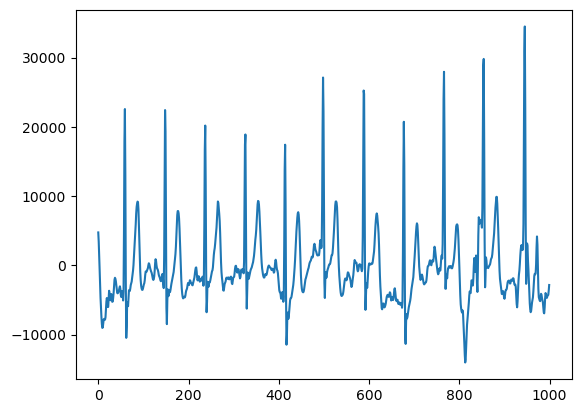

In [73]:
pd.Series(data['sternum']['ecg'][0][0][0][0][2].squeeze(0)[:1000]).plot()

In [52]:
print(data['wrist']['ppg_g'][0][0][0]['v'][0].shape)
print(data['wrist']['ppg_r'][0][0][0]['v'][0].shape)
print(data['wrist']['ppg_ir'][0][0][0]['v'][0].shape)

(1, 5679104)
(1, 5679104)
(1, 5679104)


In [5]:
from pathlib import Path 
datadir = Path(datadir)
lengths = []
for path in datadir.glob('*.mat'):
    data = loadmat(path)
    lengths.append(data['wrist']['acc_x'][0][0][0][0][2].shape[1])
    del data

In [ ]:
lengths

[5679104,
 5690368,
 6162432,
 7018496,
 6169600,
 6137856,
 6103040,
 6768640,
 6664192,
 5762048,
 6066176,
 5835776,
 6633472,
 6691840,
 6107136,
 6405120]

In [14]:
names = []
for path in datadir.glob("*.mat"):
    names.append(str(path).split("_")[-1][:3])
names

['an0',
 'e61',
 'fex',
 'k2s',
 'kjd',
 'l38',
 'n31',
 'ngh',
 'p5d',
 'p9p',
 'qm9',
 'ssx',
 'trh',
 'tz8',
 'u7y',
 'w4p']

# IEEE Dataset

The IEEE Dataset does not contain any activity labels or acceleration data. 

In [114]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/euler/IEEEPPG/Training_data/Training_data"
data = loadmat(datadir + "/DATA_01_TYPE01.mat")
hr = loadmat(datadir + "/DATA_01_TYPE01_BPMtrace.mat")
print(data['sig'].shape[1])
(8 + 2 *( hr['BPM0'].shape[0] - 1 ) ) * 125

37937


37750

In [21]:
data['whole_dataset']

array([[array([[-0.15877186, -0.73611433, -1.07146451, ..., -0.63894624,
                -0.30886573,  0.17808868],
               [-0.55416434, -0.31065377,  0.11754339, ..., -0.81839013,
                -0.93625415, -0.84427809],
               [-1.52729914, -0.58884415,  0.88678259, ..., -0.03825972,
                -0.42902249, -1.08390654],
               ...,
               [-0.76582042, -1.04059837, -1.2869529 , ...,  0.35689532,
                 0.12570946, -0.08977534],
               [ 1.40025155,  0.83537255,  0.45313321, ...,  0.93511269,
                 0.95084864,  0.79267789],
               [-0.16112841, -0.03788694,  0.10030634, ...,  0.74729059,
                 0.80550889,  0.87048167]])                             ,
        array([[33],
               [30],
               [29],
               [29],
               [30],
               [29],
               [30],
               [31],
               [33],
               [38],
               [41],
               [45],
 

<Axes: >

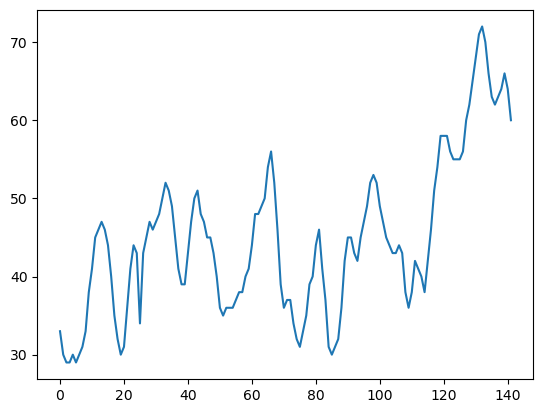

In [15]:
pd.Series(data['whole_dataset'][0][1].squeeze(1)).plot()

In [15]:
data['whole_dataset'][0][0]

array([[-0.15877186, -0.73611433, -1.07146451, ..., -0.63894624,
        -0.30886573,  0.17808868],
       [-0.55416434, -0.31065377,  0.11754339, ..., -0.81839013,
        -0.93625415, -0.84427809],
       [-1.52729914, -0.58884415,  0.88678259, ..., -0.03825972,
        -0.42902249, -1.08390654],
       ...,
       [-0.76582042, -1.04059837, -1.2869529 , ...,  0.35689532,
         0.12570946, -0.08977534],
       [ 1.40025155,  0.83537255,  0.45313321, ...,  0.93511269,
         0.95084864,  0.79267789],
       [-0.16112841, -0.03788694,  0.10030634, ...,  0.74729059,
         0.80550889,  0.87048167]])

# Chapman 

In [3]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Chapman/"
data = loadmat(datadir + "chapman.mat")


In [12]:
data['whole_data'][0][0].shape

(1000, 4)

In [23]:
df = pd.DataFrame(data['whole_data'])
df[0].values[1].shape

(1000, 4)

[1 3 2 4]


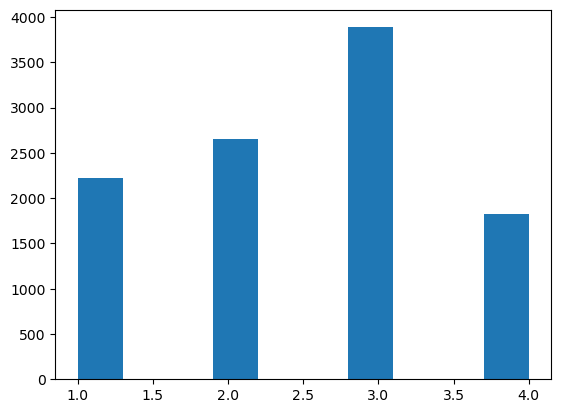

In [26]:
df = pd.DataFrame(data['whole_data'])[1].apply(lambda x: x[0][0])
plt.hist(df.values)
print(df.unique())